In [1]:
import time

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import EfficientSU2
import qiskit_algorithms.optimizers as optim
from qiskit.primitives import BackendSampler
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer import noise

from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_aer import AerSimulator
import numpy as np

In [2]:
iris_data = load_iris()

features = iris_data.data
labels = iris_data.target

# rescale the features
features = MinMaxScaler().fit_transform(features)

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [3]:
num_features = features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = EfficientSU2(num_qubits=num_features, reps=3)

In [4]:
optimizer = optim.COBYLA(maxiter=100)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title(f"Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

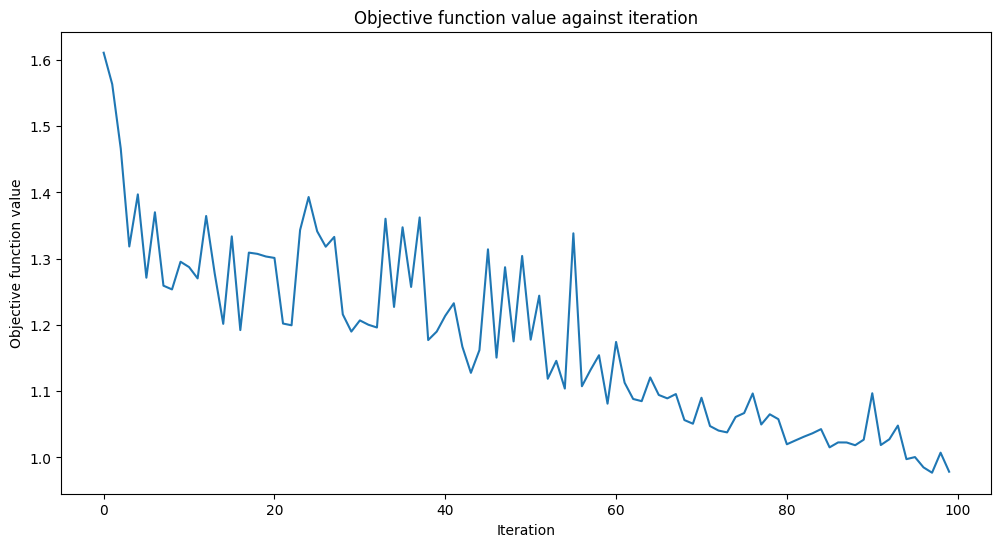

In [5]:
import numpy as np

# depolarizing noise levels
p0given1_vals = p1given0_vals = np.linspace(0, 1, 10)
r_scores = []

for i in range(len(p0given1_vals)):
    p0given1 = p0given1_vals[i]
    p1given0 = p1given0_vals[i]

    noise_model = noise.NoiseModel()
    readout_error = noise.ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
    noise_model.add_all_qubit_readout_error(readout_error)
    
    simulator = AerSimulator(noise_model=noise_model)
    vqc = VQC(
        sampler=BackendSampler(backend=simulator),
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph
    )

    objective_func_vals = []
    vqc.fit(train_features, train_labels)

    tr_score = vqc.score(train_features, train_labels)
    te_score = vqc.score(test_features, test_labels)

    r_scores.append((tr_score, te_score))

with open('r_scores.npy', 'wb') as f:
    np.save(f, r_scores)

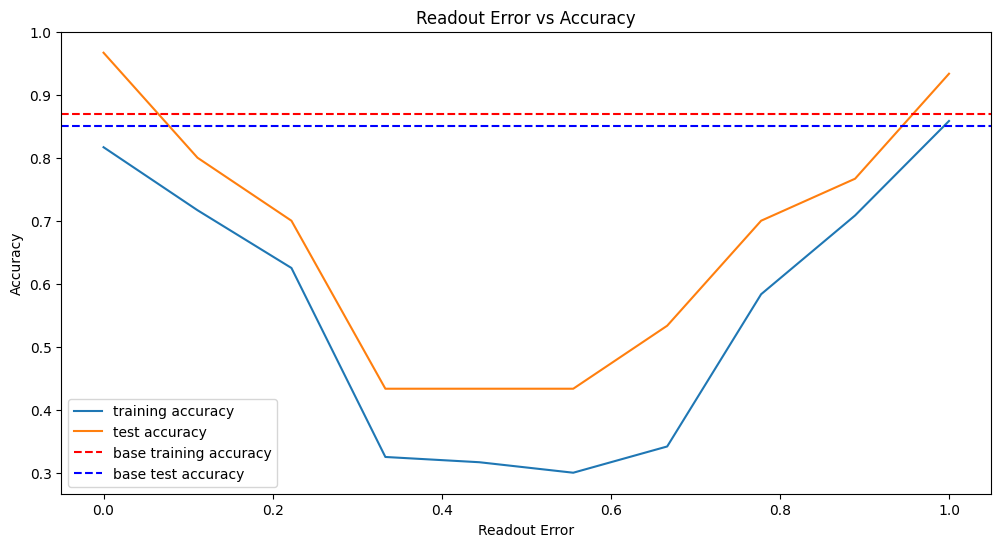

In [18]:
plt.rcParams["figure.figsize"] = (12, 6)
base_tr_acc, base_te_acc = 0.85, 0.87

plt.title("Readout Error vs Accuracy")
plt.xlabel("Readout Error")
plt.ylabel("Accuracy")
plt.plot(p0given1_vals, [sc[0] for sc in r_scores], label="training accuracy")
plt.plot(p0given1_vals, [sc[1] for sc in r_scores], label="test accuracy")

# Adding dotted lines for base test and training accuracies
plt.axhline(y=base_te_acc, color='r', linestyle='--', label="base training accuracy")
plt.axhline(y=base_tr_acc, color='b', linestyle='--', label="base test accuracy")

plt.legend()
plt.show()